# Machine Learning Project 1

## Regression analysis and resampling methods

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from numpy.random import random, seed
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

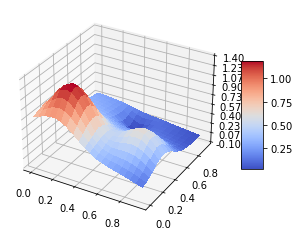

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [4]:
def create_X(x, y, n ):
    '''from x, y meshgrid vectors computes the design matrix for a polynomial model of degree n.'''
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    
    for i in range(1,n+1):
        #starting from the index after the i-1 degree
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            #combinations of powers of x and y, starting from x**i
            X[:,q+k] = (x**(i-k))*(y**k)
            
    # The design matrix is set up as 1,x,y,x**2,x*y,y**2
    return X

In [5]:
def OLS(X_train,X_test, z_train, z_test):
    beta_ols = np.linalg.pinv(X_train.T@X_train)@(X_train.T)@z_train
    z_train_tilde_ols = X_train@beta_ols
    z_test_tilde_ols = X_test@beta_ols
    return z_train_tilde_ols, z_test_tilde_ols

### Part a)

In [6]:
#number of points for each axis
n_samples = 100

#degree of the polynomial
maxdegree = 9

np.random.seed(1)
x0 = np.random.rand(n_samples)
np.random.seed(2)
y0 = np.random.rand(n_samples)

x,y = np.meshgrid(x0,y0)
X = create_X(x,y,maxdegree)
noise = 0.1*np.random.randn(X.shape[0])

z = FrankeFunction(X[:,1],X[:,2]) + noise

In [7]:
np.shape(X)

(10000, 55)

0.01009786255665062
0.010221396181984949
0.8786068874667953
0.8833038095702083


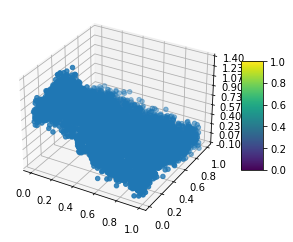

In [8]:

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)
z_train_tilde_ols, z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test)

mse_train = mean_squared_error(z_train,z_train_tilde_ols)
mse_test = mean_squared_error(z_test,z_test_tilde_ols)

r2_train = r2_score(z_train,z_train_tilde_ols)
r2_test = r2_score(z_test,z_test_tilde_ols)

print(mse_test)
print(mse_train)

print(r2_test)
print(r2_train)

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.scatter3D(X[:,1],X[:,2], z, cmap=cm.coolwarm)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [9]:
#Important to split the data set before shuffling 
def bootstrap(X_train, z_train, datapoints): 
    global X_test, z_test
    MSE = np.zeros((datapoints,2))
    n = len(z_train)
    z_test_tilde_ols = np.empty((len(z_test), datapoints))
    for i in range(datapoints):
        sequence = np.random.randint(0,n,n)
        X1_train = X_train[sequence]
        z1_train = z_train[sequence]  
        z_train_tilde_ols , z_test_tilde_ols[:,i] = OLS(X1_train, X_test, z1_train, z_test) 
        MSE[i,0] = mean_squared_error(z1_train,z_train_tilde_ols) 
        MSE[i,1] = mean_squared_error(z_test,z_test_tilde_ols[:,i])  
    return MSE, z_test_tilde_ols

In [10]:

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)
mse_bs, _ = bootstrap(X_train, z_train,100)

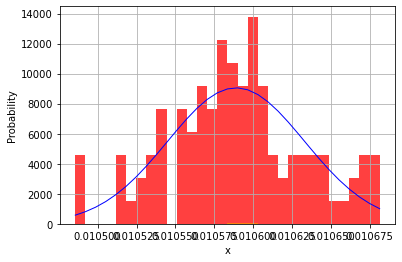

In [11]:
mse_bs = mse_bs[:,1]
n, binsboot, patches = plt.hist(mse_bs, 30, density=True, facecolor='red', alpha=0.75)
#add a 'best fit' line  
Norm = norm.pdf(binsboot, np.mean(mse_bs), np.std(mse_bs))
lt = plt.plot(binsboot, Norm, 'b', linewidth=1)
plt.hist(mse_bs)
plt.xlabel('x')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

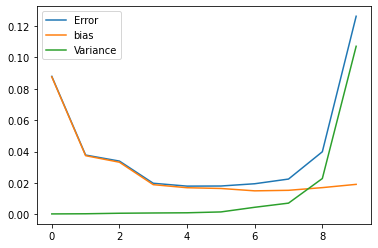

In [12]:
maxdegree = 10
n_samples = 20

np.random.seed(1)
x0 = np.random.rand(n_samples)
np.random.seed(2)
y0 = np.random.rand(n_samples)

x,y = np.meshgrid(x0,y0)
X = create_X(x,y,maxdegree)
noise = 0.1*np.random.randn(X.shape[0])

z = FrankeFunction(X[:,1],X[:,2]) + noise

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
MSE_boot = np.zeros((maxdegree,2))

for degree in range(maxdegree):
    X = create_X(x,y,degree)
    # Why needed random_state
    # The random_seed makes sure we take the same indices for spliting every time, but it is necessary to test the same
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    #X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)
 
    mse,z_pred = bootstrap(X_train, z_train,300)
    z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((z_t - z_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (z_t - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims=True) )
    #print('Polynomial degree:', degree)
    #print('Error:', error[degree])
    #print('Bias^2:', bias[degree])
    #print('Var:', variance[degree])
    #print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))
    MSE_boot[degree, 0] = np.mean(mse[:,0]) 
    MSE_boot[degree, 1] = np.mean(mse[:,1])   
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.legend()
plt.show()

In [13]:
np.mean(mse[:,1])

0.1262563847488484

In [14]:
 np.mean(mse, axis =0)

array([0.00643595, 0.12625638])

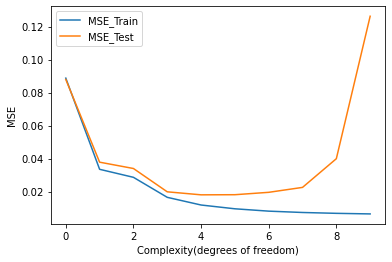

In [15]:
plt.figure()
plt.plot(polydegree,MSE_boot[:,0],label='MSE_Train')
plt.plot(polydegree,MSE_boot[:,1],label='MSE_Test')
plt.xlabel('Complexity(degrees of freedom)')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Part c)

In [16]:
def cross_validation(k_folds, X,z):
    MSE = []
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test)


        MSE.append( mean_squared_error(z_test,z_test_tilde_ols))

        return (np.mean(MSE))

In [17]:
k_folds = range(5,11)
MSE_cross = []
maxdegree = 5
X = create_X(x,y,maxdegree)
for i  in k_folds:
    k = i
    kfold = KFold(n_splits = k)
    MSE_cross.append(cross_validation(k,X,z))
    

In [18]:
k_folds = range(5,11)
MSE_boot = []
maxdegree = 5
X = create_X(x,y,maxdegree)
for i  in k_folds:
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
    z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test)
    mse,z_pred = bootstrap(X_train, z_train,i)
    MSE_boot.append(np.mean(mse)) 

In [19]:
maxdegree = 10
n_samples = 20

np.random.seed(1)
x0 = np.random.rand(n_samples)
np.random.seed(2)
y0 = np.random.rand(n_samples)

x,y = np.meshgrid(x0,y0)
X_ = create_X(x,y,maxdegree)
noise = 0.1*np.random.randn(X_.shape[0])

z = FrankeFunction(X_[:,1],X_[:,2]) + noise
MSE_test_boot = np.zeros(maxdegree)
k_folds = [5,10]
MSE_cross = np.zeros((maxdegree,2))
for degree in range(maxdegree):
    X = create_X(x,y,degree)
    # Why needed random_state
    # The random_seed makes sure we take the same indices for spliting every time, but it is necessary to test the same
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test)
    mse,_ = bootstrap(X_train, z_train,300)
    z_t = z_test.reshape(len(z_test),1)
    MSE_test_boot[degree] = np.mean(mse[:,1])
    for i  in range(len(k_folds)):
        k = k_folds[i]
        kfold = KFold(n_splits = k)
        MSE_cross[degree,i] = cross_validation(k,X,z)




In [20]:
MSE_cross

array([[0.04212564, 0.04990091],
       [0.04269128, 0.06120175],
       [0.0396868 , 0.05853419],
       [0.01963979, 0.02475915],
       [0.02282464, 0.03321681],
       [0.01648144, 0.01910623],
       [0.02245908, 0.03206101],
       [0.01756437, 0.01519473],
       [0.01278738, 0.02433591],
       [0.06651302, 0.12976535]])

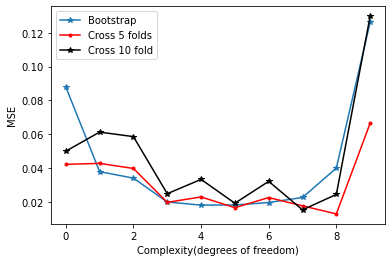

In [21]:
plt.figure()
plt.plot(range(maxdegree),MSE_test_boot,"*-",label = 'Bootstrap')
plt.plot(range(maxdegree),MSE_cross[:,0],"r.-", label ='Cross 5 folds' )
plt.plot(range(maxdegree),MSE_cross[:,1],"k*-", label = 'Cross 10 fold' )
plt.xlabel('Complexity(degrees of freedom)')
plt.ylabel('MSE')
plt.legend()
plt.show()